In [1]:
import numpy as np
from numpy import random
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
import torch.nn.functional as F

In [3]:
#seed = random.randint(100)
#seed = 54
#np.random.seed(seed)
torch.manual_seed(30)

In [4]:
# Import RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler

In [5]:
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'difficulty_level'
]

In [6]:
u2r_attacks = [
    "buffer_overflow",
    "loadmodule",
    "perl",
    "rootkit"
]

In [7]:
r2l_attacks = ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy', 'warezclient', 'warezmaster', 'snmpgetattack', 'named', 'sendmail', 'snmpguess', 'worm', 'xlock', 'xsnoop', 'httptunnel']

In [8]:
# Load the NSL-KDD dataset
train_file = "P:\Study\CSUN\Thesis Code\KDDTrain+.txt"
test_file = "P:\Study\CSUN\Thesis Code\KDDTest+.txt"

In [9]:
# Load NSL-KDD dataset
train_data = pd.read_csv(train_file, header=None, names=column_names)
test_data = pd.read_csv(test_file, header=None, names=column_names)

In [10]:
# Drop "num_outbound_cmds" and "difficulty_level" columns
train_data = train_data.drop(columns=["num_outbound_cmds", "difficulty_level"])
test_data = test_data.drop(columns=["num_outbound_cmds", "difficulty_level"])

In [11]:
print(train_data.shape)
print(test_data.shape)

(125973, 41)
(22544, 41)


In [12]:
train_data = train_data[train_data['attack_type'].isin(u2r_attacks + ['normal'])]
test_data = test_data[test_data['attack_type'].isin(u2r_attacks + ['normal'])]

In [13]:
print(train_data.shape)
print(test_data.shape)

(67395, 41)
(9748, 41)


In [14]:
# Replace class labels
train_data['is_u2r'] = train_data['attack_type'].apply(lambda x: 1 if x in u2r_attacks else 0)
test_data['is_u2r'] = test_data['attack_type'].apply(lambda x: 1 if x in u2r_attacks else 0)

In [15]:
train_data = train_data.drop('attack_type', axis=1)
test_data = test_data.drop('attack_type', axis=1)

In [16]:
# Separate features and labels
X_train = train_data.drop(columns=['is_u2r'])
y_train = train_data['is_u2r']

In [17]:
# Perform under-sampling
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [18]:
# Create a new DataFrame with the resampled data
train_data = pd.concat([X_train_resampled, y_train_resampled], axis=1)

In [19]:
# Merge train and test data
combined_data = pd.concat([train_data, test_data], axis=0)

categorical_columns = ["protocol_type", "service", "flag"]

# Initialize the OneHotEncoder and fit_transform the combined_data
encoder = OneHotEncoder()
combined_data_encoded = encoder.fit_transform(combined_data[categorical_columns])

# Convert the encoded data into a DataFrame and set appropriate column names
encoded_df = pd.DataFrame(combined_data_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_columns))

# Reset the index of the combined_data and encoded_df DataFrames
combined_data.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

# Drop the original categorical columns and concatenate the encoded_df with combined_data
combined_data.drop(categorical_columns, axis=1, inplace=True)
combined_data_encoded = pd.concat([combined_data, encoded_df], axis=1)

# Split the combined_data_encoded DataFrame back into train_data and test_data
train_data_encoded = combined_data_encoded.iloc[:len(train_data), :]
test_data_encoded = combined_data_encoded.iloc[len(train_data):, :]

# Reset the index of train_data_encoded and test_data_encoded DataFrames
train_data_encoded.reset_index(drop=True, inplace=True)
test_data_encoded.reset_index(drop=True, inplace=True)

In [20]:
# Extract features and labels
X_train = train_data_encoded.drop('is_u2r', axis=1).values
y_train = train_data_encoded['is_u2r'].values
X_test = test_data_encoded.drop('is_u2r', axis=1).values
y_test = test_data_encoded['is_u2r'].values

In [21]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
class ProtoNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ProtoNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.encoder(x)

def euclidean_distance(a, b):
    return torch.sqrt(torch.sum((a - b) ** 2, dim=1))

def prototypical_loss(prototypes, query_set, targets, n_support):
    distances = euclidean_distance(query_set.unsqueeze(1), prototypes.unsqueeze(0))
    
    # Apply the softmax function to the negative distances
    probabilities = F.softmax(-distances, dim=1)

    # Compute the cross-entropy loss 
    loss = F.cross_entropy(probabilities, targets)
    
    return loss

class BinaryDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [23]:
# Create datasets
train_dataset = BinaryDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = BinaryDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

In [24]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=40, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=40, shuffle=False)

In [25]:
# Set up the network
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ProtoNet(input_dim, hidden_dim, output_dim).to(device)

In [26]:
# Training
epochs = 10
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_support = 10

In [27]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for batch in train_loader:
        data, labels = batch
        data, labels = data.to(device), labels.to(device)

        # Assuming you have balanced classes in each batch, you can compute the number of classes:
        n_classes = len(np.unique(labels.cpu().numpy()))

        # Select the support set and query set
        support_set = data[:n_support * n_classes]
        query_set = data[n_support * n_classes:]
        targets = labels[n_support * n_classes:]

        # Calculate prototypes
        model.zero_grad()
        support_set_embeddings = model(support_set)
        prototypes = torch.mean(support_set_embeddings.view(n_classes, n_support, output_dim), dim=1)
        
        # Calculate loss
        query_set_embeddings = model(query_set)
        loss = prototypical_loss(prototypes, query_set_embeddings, targets, n_support)

        # Update weights
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader)}')

Epoch 1/10, Loss: 4.158504168192546
Epoch 2/10, Loss: 4.15819787979126
Epoch 3/10, Loss: 4.1564920743306475
Epoch 4/10, Loss: 4.156451384226481
Epoch 5/10, Loss: 4.155677795410156
Epoch 6/10, Loss: 4.1539130210876465
Epoch 7/10, Loss: 4.153253078460693
Epoch 8/10, Loss: 4.15421994527181
Epoch 9/10, Loss: 4.15233580271403
Epoch 10/10, Loss: 4.151850700378418


In [28]:
# Testing
model.eval()
with torch.no_grad():
    # Embed test and train data
    embeddings_test = model(torch.tensor(X_test, dtype=torch.float32).to(device))
    embeddings_train = model(torch.tensor(X_train, dtype=torch.float32).to(device))

    # Calculate prototypes for each class
    unique_classes = torch.unique(torch.tensor(y_train)).tolist()
    prototypes = []
    for cls in unique_classes:
        class_indices = (y_train == cls)
        class_embeddings = embeddings_train[class_indices]
        prototype = torch.mean(class_embeddings, dim=0)
        prototypes.append(prototype)
    prototypes = torch.stack(prototypes)

    # Calculate distances and make predictions
    distances = torch.cdist(embeddings_test, prototypes, p=2)
    _, predicted_indices = torch.min(distances, dim=1)

    # Convert predicted indices to match original labels
    predicted_labels = []
    for pred in predicted_indices:
        predicted_labels.append(unique_classes[pred.item()])

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predicted_labels)
    print(f'Test Accuracy: {accuracy}')

    # Print classification report and confusion matrix
    print(classification_report(y_test, predicted_labels))
    print(confusion_matrix(y_test, predicted_labels))

Test Accuracy: 0.9569142388182191
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      9711
           1       0.07      0.89      0.14        37

    accuracy                           0.96      9748
   macro avg       0.54      0.92      0.56      9748
weighted avg       1.00      0.96      0.97      9748

[[9295  416]
 [   4   33]]


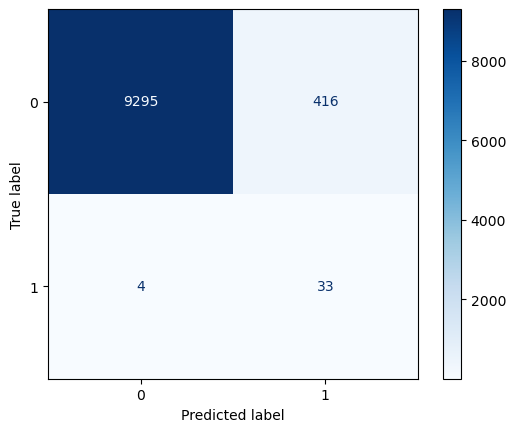

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = 'Blues')